.. meta::
   :description: Using the responsible AI toolbox to build workflows.

> Copyright (c) 2022 Massachusetts Institute of Technology  
> SPDX-License-Identifier: MIT 



# Building a Workflows for Cross Validation and Adversarial Robustness
This notebook demonstrates how the to build experiment workflows for configurable, repeatable, and scalable (CRS) experimentation.  Two basic workflows will be demonstrated in this tutorial:

- Cross-Validation Workflow: Demonstrates how to build scalable cross validation training workflow.
- Robustness Curve Workflow: Demonstrates how to build scalable robustness testing for each of the models trained in the "Cross-Validation Workflow"

## Getting Started


We will install the rAI-toolbox and then we will create a Jupyter notebook in which we will complete this tutorial.


### Installing `rai_toolbox`


To install the toolbox (along with its `mushin` capabilities) in your Python environment, run the following command in your 
terminal:

```console
$ pip install rai-toolbox[mushin]
```

To verify that the toolbox is installed as-expected, open a Python console and try 
importing ``rai_toolbox``.

```python
>>> import rai_toolbox
```

You will also need to install scikit-learn; please follow [these instructions](https://scikit-learn.org/stable/install.html#installing-scikit-learn).


## Opening a Jupyter notebook

If you do not have Jupyter Notebook or Jupyter Lab installed in your Python environment, please follow [these instructions](https://jupyter.org/install).
Now open a terminal on your computer and [start a notebook/lab session](http://www.pythonlikeyoumeanit.com/Module1_GettingStartedWithPython/Jupyter_Notebooks.html).
A file-viewer will open in an internet browser; pick a directory where you are okay with saving some PyTorch model weights. Create a notebook called `Building-Workflows.ipynb`. You can then follow along with this tutorial by copying, pasting, and running the code blocks below in the cells of your notebook.

Note: you may also need to install the `ipywidgets` package in your Python environment to configure the notebook to  display ipywidgets:

```console
$ pip install ipywidgets
```

## Imports

In [1]:
from collections import defaultdict
from pathlib import Path
from typing import Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import torch as tr

In [2]:
# Hydra and hydra-zen
from hydra.core.config_store import ConfigStore
from hydra_zen import MISSING, builds, instantiate, load_from_yaml, make_config

# Lightning
from pytorch_lightning import LightningModule, Trainer

# sklearn and torch
from sklearn.model_selection import StratifiedKFold
from torch import Tensor, nn
from torch.optim import Optimizer
from torch.utils.data import DataLoader, Subset
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

# rAI-toolbox
from rai_toolbox._typing import Partial
from rai_toolbox.mushin import load_from_checkpoint
from rai_toolbox.mushin.lightning import MetricsCallback
from rai_toolbox.mushin.workflows import (
    MultiRunMetricsWorkflow,
    RobustnessCurve,
    multirun,
)


## Experiment Functions and Classes

Here we define two Neural Network models, a fully linear neural network and a convolutional neural network.

In [3]:
class ConvModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 5, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(32, 32, 3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(3),
            nn.Conv2d(32, 32, 3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 10, 3),
            nn.Flatten(1),
        )

    def forward(self, x):
        return self.model(x)

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(1),
            nn.Linear(28 * 28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        return self.model(x)

Next lets define a function that takes the `MNIST` dataset and splits the data into training and validation sets using SciKit-Learn's [StratifiedKFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).  This allows us to split the dataset into "folds" and select the fold for each experiment.

In [4]:
def split_dataset(dataset: MNIST, n_splits: int, fold: int) -> Tuple[Subset, Subset]:
    """Provide training and validation splits using `sklearn.model_selection.StratifiedKfold`"""

    kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state = 49)
    train_indices, val_indices = list(kfold.split(range(len(dataset)), dataset.targets))[fold]
    return Subset(dataset, train_indices), Subset(dataset, val_indices)

Now define the [LightningModule](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.core.LightningModule.html#pytorch_lightning.core.LightningModule) for training and testing.

In [5]:
class StandardModule(LightningModule):
    def __init__(
        self,
        *,
        model: nn.Module,
        dataset: MNIST,
        optimizer: Optional[Partial[Optimizer]] = None,
        perturber = None,
        fold: int = 0,
        n_splits: int = 5,
        batch_size: int = 100,
        num_workers: int = 4,
    ) -> None:
        super().__init__()
        self.dataset = dataset
        self.optimizer = optimizer
        self.criterion = nn.CrossEntropyLoss()
        self.model = model
        self.perturber = perturber
        self.n_splits = n_splits
        self.fold = fold
        self.batch_size = batch_size
        self.num_workers = num_workers

        # Metrics
        self.acc_metric = Accuracy()
        if self.perturber:
            self.clean_acc_metric = Accuracy()

    def forward(self, data: Tensor) -> Tensor:
        return self.model(data)

    def train_dataloader(self) -> DataLoader:
        train_dataset, _ = split_dataset(self.dataset, self.n_splits, self.fold)
        return DataLoader(train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self) -> DataLoader:
        _, val_dataset = split_dataset(self.dataset, self.n_splits, self.fold)
        return DataLoader(val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self) -> DataLoader:
        return DataLoader(self.dataset, batch_size=self.batch_size, num_workers=self.num_workers)

    def configure_optimizers(self) -> Optional[Optimizer]:
        if self.optimizer:
            return self.optimizer(self.model.parameters())
        return None

    def _step(self, batch, stage: str) -> Tensor:
        data_orig, target = batch

        if self.perturber:
            with tr.no_grad():
                output = self.model(data_orig)
                loss = self.criterion(output, target)
                acc = self.clean_acc_metric(output, target)
                self.log(f"{stage}_clean_accuracy", acc)

            data, adv_loss = self.perturber(
                model=self.model, data=data_orig, target=target
            )
            self.log(f"{stage}_adversarial_loss", adv_loss.mean().item())

        else:
            data = data_orig

        output = self.model(data)
        loss = self.criterion(output, target)
        acc = self.acc_metric(output, target)
        self.log(f"{stage}_loss", loss)
        self.log(f"{stage}_accuracy", acc)
        return loss

    def training_step(self, batch, batch_idx) -> Tensor:
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx) -> Tensor:
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx) -> Tensor:
        return self._step(batch, "test")

## hydra-zen Configuration

Now that we have our models lets setup the configurations for our experiments.

In [6]:
Augmentations = builds(transforms.Compose, [builds(transforms.RandomCrop, size=28, padding=4), builds(transforms.ToTensor)])
TrainDataset = builds(MNIST, root="${data_dir}", train=True, transform=Augmentations)
TestDataset = builds(MNIST, root="${data_dir}", train=False, transform=builds(transforms.ToTensor))
ConvModelCfg = builds(ConvModel)
LinearModelCfg = builds(LinearModel)
Optim = builds(tr.optim.SGD, lr=0.1, zen_partial=True)

from rai_toolbox.optim import L2ProjectedOptim, LinfProjectedOptim
from rai_toolbox.perturbations import gradient_ascent
L2PGD = builds(L2ProjectedOptim, zen_partial=True)
LinfPGD = builds(LinfProjectedOptim, zen_partial=True)

def lr_for_pgd(epsilon, num_steps):
    return 2.5 * epsilon / num_steps

Perturber = builds(
    gradient_ascent,
    optimizer="${optimizer}",
    epsilon="${epsilon}",
    steps="${steps}",
    lr=builds(lr_for_pgd, "${epsilon}", "${steps}"),
    zen_partial=True,
    populate_full_signature=True
)

PLModule = builds(
    StandardModule,
    model="${model}",
    fold="${fold}",
    n_splits="${n_splits}",
    dataset=TrainDataset,
    optimizer=Optim,
    perturber="${perturber}",
    populate_full_signature=True,
)


EvalPLModule = builds(
    StandardModule,
    model="${model}",
    dataset=TestDataset,
    perturber="${perturber}",
    populate_full_signature=True,
)


TrainerCfg = builds(
    Trainer,
    max_epochs=10,
    accelerator="auto",
    devices=1,
    enable_progress_bar=False,
    enable_model_summary=False,
    callbacks=[builds(MetricsCallback)], 
    populate_full_signature=True
)

Now we use Hydra's [ConfigStore](https://hydra.cc/docs/tutorials/structured_config/config_store/) API to store configurations in memory and allow for swapping of configurations at runtime.

In [7]:
cs = ConfigStore.instance()
cs.store(name="cnn", group="model", node=ConvModelCfg)
cs.store(name="linear", group="model", node=LinearModelCfg)
cs.store(name="l2pgd", group="optimizer", node=L2PGD)
cs.store(name="linfpgd", group="optimizer", node=LinfPGD)

## Cross Validation Workflow

With all the configurations in place we can now define our first experiment workflow: train multiple models on `MNIST` data using cross-validation.  First define the main experiment configuration:

In [8]:
Config = make_config(
    defaults = [
        "_self_",
        {"model": "linear"},
    ],
    data_dir = "${oc.env:HOME}/.torch/data",
    model=MISSING,
    module=PLModule,
    trainer=TrainerCfg,
    perturber=None,
    fold=0,
    n_splits=5,
)

Create `CrossValWorkflow` by inheriting from [MultiRunMetricsWorkflow](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.mushin.MultiRunMetricsWorkflow.html) to train a given model for a given a cross validation dataset (fold).  The task function simply runs PyTorch Lightning's [Trainer.fit](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.Trainer.html#pytorch_lightning.trainer.trainer.Trainer) and returns the metrics saved from [MetricsCallback](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.mushin.MetricsCallback.html).  To run this workflow simply define the number of cross validation splits to use via `n_splits`.

In [9]:
class CrossValWorkFlow(MultiRunMetricsWorkflow):
    @staticmethod
    def evaluation_task(trainer: Trainer, module: LightningModule):
        trainer.fit(module)
        return tr.load("fit_metrics.pt")

    def run(self, n_splits: int, **run_kwargs):
        fold = multirun(range(n_splits))
        super().run(n_splits=n_splits, fold=fold, **run_kwargs)

Now run the workflow by defining the requried `n_splits` and the models (names defined in the [ConfigStore](https://hydra.cc/docs/tutorials/structured_config/config_store/) above).  Additionally we define the working directory of the experiment by setting `hydra.sweep.dir` configuration via `overrides`.

In [10]:
kfold_task = CrossValWorkFlow(Config)
kfold_task.run(n_splits=2, model=multirun(["linear", "cnn"]), overrides=["hydra.sweep.dir=outputs/cross_validation/${now:%Y-%m-%d}/${now:%H-%M-%S}"])
## You can load previous experiments
# kfold_task = CrossValWorkFlow().load_from_dir("outputs/cross_validation/2022-05-11/14-42-14", metrics_filename="fit_metrics.pt")

[2022-05-11 14:42:14,746][HYDRA] Launching 4 jobs locally
[2022-05-11 14:42:14,747][HYDRA] 	#0 : n_splits=2 fold=0 model=linear


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-11/14-42-14/0/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


[2022-05-11 14:42:57,959][HYDRA] 	#1 : n_splits=2 fold=0 model=cnn


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-11/14-42-14/1/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


[2022-05-11 14:43:38,860][HYDRA] 	#2 : n_splits=2 fold=1 model=linear


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-11/14-42-14/2/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


[2022-05-11 14:44:17,398][HYDRA] 	#3 : n_splits=2 fold=1 model=cnn


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-11/14-42-14/3/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


In [11]:
kfold_task.working_dir

PosixPath('outputs/cross_validation/2022-05-11/14-42-14')

Once the task is finished we can load in the metrics to an [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) using the `to_xarray` method.

In [12]:
xdata = kfold_task.to_xarray(coord_from_metrics="epoch")
xdata

<xarray.Dataset>
Dimensions:         (fold: 2, model: 2, epoch: 10)
Coordinates:
  * fold            (fold) int64 0 1
  * model           (model) <U6 'linear' 'cnn'
  * epoch           (epoch) int64 0 1 2 3 4 5 6 7 8 9
Data variables:
    train_loss      (fold, model, epoch) float64 1.935 1.07 ... 0.06686 0.1
    train_accuracy  (fold, model, epoch) float64 0.33 0.56 0.74 ... 0.98 0.98
    val_loss        (fold, model, epoch) float64 1.887 1.097 ... 0.06575 0.1214
    val_accuracy    (fold, model, epoch) float64 0.367 0.6238 ... 0.9785 0.9617
Attributes:
    n_splits:  2

We can use XArray to plot the validation accuracy over training epochs for each fold or aggregrate the mean across all folds.

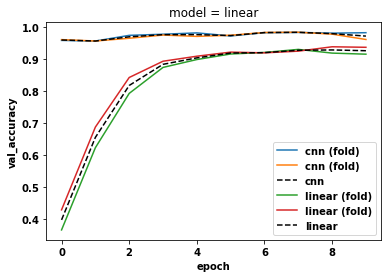

In [13]:
fig, ax = plt.subplots()
for name, g in xdata.groupby("model"):
    g.val_accuracy[:, 0].plot.line(x="epoch", label=f"{name} (fold)", ax=ax)
    g.val_accuracy[:, 0].mean("fold").plot.line(x="epoch", label=name, ax=ax, linestyle="--", color="k")
plt.legend()

## Robustness Curve

Now that we have trained some models lets evalulate robustness of each model to adversarial perturbations.  To create a configuration and workflow we need to provide the following for our task:

- The experiment directory containing the experiment parameters and model checkpoint for training
- The perturbation type and perturbation magnitude (`epsilon`)

Below we define a function that extracts the configuration of the model defined by in the experiment YAML file while the checkpoint is found within the training experiment directory.  This makes sure we load the correct model configuration and checkpoint for testing.

In [21]:
def load_model_from_experiment(exp_dir: Union[Path, str]):
    # Load configuration for experiment
    exp_dir = Path(exp_dir)
    exp_cfg = exp_dir / ".hydra/config.yaml"
    assert exp_cfg.exists()
    exp_cfg = load_from_yaml(exp_cfg)
    model = instantiate(exp_cfg.model)

    # get path to model checkpoint in experiment directory
    # and load to model
    ckpts = list(exp_dir.glob("**/*.ckpt"))
    assert len(ckpts) == 1
    ckpt = ckpts[0]
    load_from_checkpoint(
        model,
        ckpt=ckpt,
        weights_key="state_dict",
        weights_key_strip="model.",
    )

    return model

Now we can define our experiment configuration file.

In [14]:
TestConfig = make_config(
    defaults = [
        "_self_",
        {"optimizer": "l2pgd"},
    ],
    data_dir = "${oc.env:HOME}/.torch/data",
    exp_dir=MISSING,
    trainer=TrainerCfg,
    module=EvalPLModule,
    model=builds(load_model_from_experiment, exp_dir="${exp_dir}"),
    perturber=Perturber,
    optimizer=MISSING,
    epsilon=0.0,
    steps=10,
)

The workflow inherits from [RobustnessCurve](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.mushin.RobustnessCurve.html).  Other than the basic task function to use [Trainer.test](https://pytorch-lightning.readthedocs.io/en/latest/api/pytorch_lightning.trainer.trainer.Trainer.html#pytorch_lightning.trainer.trainer.Trainer) and return the test metrics saved by [MetricsCallback](https://mit-ll-responsible-ai.github.io/responsible-ai-toolbox/generated/rai_toolbox.mushin.MetricsCallback.html), this workflow extends the basic interface for `RobustnessCurve` to:

- Load and correlate the training experiment parameters model and fold to the robustness curve experiments
- Update the [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) with the training experiment parameters

In [15]:
class ExperimentRobustnessCurve(RobustnessCurve):
    @staticmethod
    def evaluation_task(trainer: Trainer, module: LightningModule):
        trainer.test(module)
        return tr.load("test_metrics.pt")

    def _load_exp_overrides(self, working_dir: Union[str, Path], config_dir: str = ".hydra"):
        ################################################
        # Load multirun values from experiment directory
        ################################################
        multirun_cfg = Path(working_dir) / "multirun.yaml"
        assert (
            multirun_cfg.exists()
        ), "Working directory does not contain `multirun.yaml` file.  Be sure to use the value of the Hydra sweep directory for the workflow"

        self._exp_multirun_task_overrides = defaultdict(list)
        overrides = load_from_yaml(multirun_cfg).hydra.overrides.task
        for o in overrides:
            k, v = o.split("=")
            if k == "exp_dir":
                dirs = v.split(",")
                for dir in dirs:
                    overrides = load_from_yaml(
                        Path(dir) / f"{config_dir}/overrides.yaml"
                    )
                    output = self._parse_overrides(overrides)

                    for ko, vo in output.items():
                        self._exp_multirun_task_overrides[ko].append(vo)


                break

        return self

    def jobs_post_process(self):
        super().jobs_post_process()
        self._load_exp_overrides(self.working_dir)

    def load_from_dir(self,
        working_dir: Union[Path, str],
        config_dir: str = ".hydra",
        metrics_filename: str = "test_metrics.pt",
    ) -> "ExperimentRobustnessCurve":
        super().load_from_dir(working_dir=working_dir, config_dir=config_dir, metrics_filename=metrics_filename)
        self._load_exp_overrides(working_dir=working_dir, config_dir=config_dir)
        return self

    def to_xarray(self, non_multirun_params_as_singleton_dims: bool = False):
        xdata = super().to_xarray(non_multirun_params_as_singleton_dims=non_multirun_params_as_singleton_dims)

        ##################################
        # Add multirun coordinates to data
        ##################################
        exp_dir = xdata.coords["exp_dir"]
        coords = {}
        for k, v in self._exp_multirun_task_overrides.items():
            if len(v) == len(exp_dir):
                uv = list(set(np.unique(v)))
                if len(uv) > 1 or non_multirun_params_as_singleton_dims:
                    coords[k] = (["exp_dir"], v)

        return xdata.assign_coords(coords)

Run the experiment by first defining the main experiment directory for each cross-validation experiment and providing the `epsilon` values for the calculating the $\ell_2$ adverarial perturbations.

In [16]:
exp_dir = [m.parent for m in kfold_task.working_dir.absolute().glob("**/fit_metrics.pt")]

robustness_curve_task = ExperimentRobustnessCurve(TestConfig)
robustness_curve_task.run(epsilon=[0,1,2], exp_dir=multirun(exp_dir), overrides=["hydra.sweep.dir=outputs/robustness_curves/${now:%Y-%m-%d}/${now:%H-%M-%S}"])

## You can load an old experiment
# robustness_curve_task = ExperimentRobustnessCurve().load_from_dir("outputs/robustness_curves/2022-05-11/14-45-02")

[PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-11/14-42-14/0'),
 PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-11/14-42-14/1'),
 PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-11/14-42-14/2'),
 PosixPath('/home/justin_goodwin/projects/raiden/rai_toolbox/docs/source/tutorials/outputs/cross_validation/2022-05-11/14-42-14/3')]

In [18]:
robustness_curve_task.working_dir

PosixPath('outputs/robustness_curves/2022-05-11/14-45-02')

Extract the [xarray.Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html).

In [19]:
rdata = robustness_curve_task.to_xarray()
rdata

<xarray.Dataset>
Dimensions:                (exp_dir: 4, epsilon: 3)
Coordinates:
  * exp_dir                (exp_dir) <U117 '/home/justin_goodwin/projects/rai...
  * epsilon                (epsilon) int64 0 1 2
    fold                   (exp_dir) int64 0 0 1 1
    model                  (exp_dir) <U6 'linear' 'cnn' 'linear' 'cnn'
Data variables:
    test_clean_accuracy    (exp_dir, epsilon) float64 0.9399 0.9399 ... 0.9621
    test_adversarial_loss  (exp_dir, epsilon) float64 0.1919 3.868 ... 13.89
    test_loss              (exp_dir, epsilon) float64 0.1919 3.868 ... 13.89
    test_accuracy          (exp_dir, epsilon) float64 0.9399 0.2231 ... 0.0011

And lastly plot the curves for each cross-validation experiment along with the mean curve for each model.

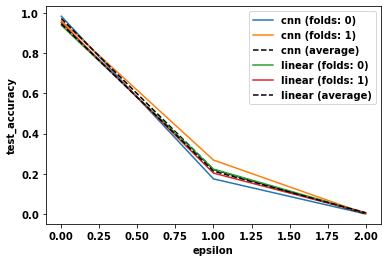

In [20]:
fig, ax = plt.subplots()
for name, g in rdata.groupby("model"):
    for fold, gf in g.groupby("fold"):
        gf.test_accuracy.plot.line(x="epsilon", label=f"{name} (folds: {fold})", ax=ax)
    g.test_accuracy.mean("exp_dir").plot.line(x="epsilon", label=f"{name} (average)", ax=ax, linestyle="--", color="k")

plt.legend()

That's it! Workflows have the potential to help scale experiments while easily allowing one to load and evalulate results.